In [245]:
import queue
import numpy as np
import math
import matplotlib.pyplot as plt

# Traffic Curve Lookup Table

In [109]:
speed_lim = []
for i in range(0,22):
    b = i/100
    s = 9.9
    c = (b*s)/4
    speed_lim.append([b,c,s])

In [110]:
lookup = []
for i in range(54,100):
    s = i/10
    b = 4.0/(4.0+0.675*s+0.076*(s**2))
    c = s/(4.0+0.675*s+0.076*(s**2))
    lookup.append([b,c,s])
lookup = lookup[::-1]

In [111]:
lookup = speed_lim + lookup

In [112]:
for i in range(41,76):
    b = i/100
    c = 0.54*math.exp(-(b-0.40)*6.799)
    s = (4*c)/b
    lookup.append([b,c,s])

In [113]:
for i in range(76,101):
    b = i/100
    c = 0.05
    s = 0.27
    lookup.append([b,c,s])

In [114]:
lookup = np.array(lookup)

In [115]:
curve = []
for i in range(0,101):
    l = i/100
    row = lookup[(lookup[:,0]>=l) & (lookup[:,0]<l+0.01)].mean(axis=0).tolist()
    row[0] = l
    row[1] = round(row[1],2)
    row[2] = round(row[2],2)
    curve.append(row)

In [164]:
curve = np.array(curve)

# Simulator

In [655]:
class simulator:
    def __init__(self, edges, lengths, input_edges, next_edge, curve, merges):
        self.edges = edges
        self.lengths = lengths
        self.input_edges = input_edges
        self.next_edge = next_edge
        self.curve = curve
        self.merges = merges
        self.time = 0
        self.throughput = []
        self.buffers = {}
        self.edge_inputs = {}
        self.edge_outputs = {}
        self.eligible = {}
        for edge in self.edges:
            self.buffers[edge] = queue.Queue(int(self.lengths[edge]/4))
            self.edge_inputs[edge] = 0
            self.edge_outputs[edge] = 0
            self.eligible[edge] = 0
    
    def iteration_nosignal(self,input_rate):
        self.time = self.time + 1
        for edge in self.edges:
            for i in range(self.buffers[edge].qsize()):
                if(self.buffers[edge].qsize()):
                    if(self.buffers[edge].queue[i][1]>self.time):
                        self.eligible[edge] = i
                        break
            b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
            if(self.eligible[edge]):
                self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
                if(self.edge_outputs[edge]>=1):
                    _ = self.buffers[edge].get()
                    self.edge_outputs[edge] -= 1
                    next_edge = self.next_edge[edge]
                    if(next_edge is not None):
                        b_next = self.buffers[next_edge].qsize()/(self.lengths[next_edge]/4)
                        self.buffers[next_edge].put((self.time,self.time+(self.lengths[next_edge]/self.curve[self.curve[:,0]==b_next][0][2])),\
                                                   timeout=0.1)
                    else:
                        self.throughput.append(self.time)
            if edge in self.input_edges:
                self.edge_inputs[edge] += input_rate[edge]
                if(self.edge_inputs[edge]>=1):
                    self.buffers[edge].put((self.time,self.time+(self.lengths[edge]/self.curve[self.curve[:,0]==b][0][2])), timeout=0.1)
                    self.edge_inputs[edge] -= 1    
    
    def iter_merge_equisignal(self,in_edges,out_edge):
        schedule = {i:in_edges[i] for i in range(len(in_edges))}
        for edge in in_edges+[out_edge]:
            b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
            scheduled_edge = schedule[(self.time//10)%len(in_edges)]
            if(self.eligible[edge]):
                if(edge in in_edges):
                    if(edge==scheduled_edge):
                        self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
                        if(self.edge_outputs[edge]>=1):
                            _ = self.buffers[edge].get()
                            self.edge_outputs[edge] -= 1
                            b_out = self.buffers[out_edge].qsize()/(self.lengths[out_edge]/4)
                            self.buffers[out_edge].put((self.time,self.time+(self.lengths[out_edge]/self.curve[self.curve[:,0]==b_out][0][2])),\
                                                       timeout=0.1)
                else:
                    
                    self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
                    if(self.edge_outputs[edge]>=1):
                        _ = self.buffers[edge].get()
                        self.edge_outputs[edge] -= 1
                        next_edge = self.next_edge[edge]
                        if(next_edge is not None):
                            b_next = self.buffers[next_edge].qsize()/(self.lengths[next_edge]/4)
                            self.buffers[next_edge].put((self.time,self.time+(self.lengths[next_edge]/self.curve[self.curve[:,0]==b_next][0][2])),\
                                                       timeout=0.1)
                        else:
                            self.throughput.append(self.time)
    
    def iteration_equisignal(self,input_rate):
        self.time = self.time + 1
        for edge in self.edges:
            for i in range(self.buffers[edge].qsize()):
                if(self.buffers[edge].qsize()):
                    if(self.buffers[edge].queue[i][1]>self.time):
                        self.eligible[edge] = i
                        break
            b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
            if edge in self.input_edges:
                self.edge_inputs[edge] += input_rate[edge]
                if(self.edge_inputs[edge]>=1):
                    self.buffers[edge].put((self.time,self.time+(self.lengths[edge]/self.curve[self.curve[:,0]==b][0][2])), timeout=0.1)
                    self.edge_inputs[edge] -= 1
                    
        all_edges = set(self.edges)
        union_merge = set()
        for merge in merges:
            in_edges, out_edge = merge[0], merge[1]
            self.iter_merge_equisignal(in_edges,out_edge)
            union_merge.union(set(in_edges))
            union_merge.union({out_edge})
        rem_edges = all_edges - union_merge
        if(rem_edges is not None):
            for edge in rem_edges:
                b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
                if(self.eligible[edge]):
                    self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
                    if(self.edge_outputs[edge]>=1):
                        _ = self.buffers[edge].get()
                        self.edge_outputs[edge] -= 1
                        next_edge = self.next_edge[edge]
                        if(next_edge is not None):
                            b_next = self.buffers[next_edge].qsize()/(self.lengths[next_edge]/4)
                            self.buffers[next_edge].put((self.time,self.time+(self.lengths[next_edge]/self.curve[self.curve[:,0]==b_next][0][2])),\
                                                       timeout=0.1)
                        else:
                            self.throughput.append(self.time)
                    
    def iter_merge_self_regulate(self,in_edges,out_edge):
        for edge in in_edges+[out_edge]:
            if(edge not in in_edges):
                b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
                if(self.eligible[edge]):
                    self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
                    if(self.edge_outputs[edge]>=1):
                        _ = self.buffers[edge].get()
                        self.edge_outputs[edge] -= 1
                        self.throughput.append(self.time)
            else:
                if(self.eligible[edge]):
                    b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
                    alpha = self.get_alpha(in_edges,out_edge)
                    self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]*min(1,alpha)
                    if(self.edge_outputs[edge]>=1):
                        _ = self.buffers[edge].get()
                        self.edge_outputs[edge] -= 1
                        next_edge = self.next_edge[edge]
                        b_next = self.buffers[next_edge].qsize()/(self.lengths[next_edge]/4)
                        self.buffers[next_edge].put((self.time,self.time+(self.lengths[next_edge]/self.curve[self.curve[:,0]==b_next][0][2])),\
                                                   timeout=0.1)
    
    
    def iteration_self_regulate(self,input_rate):
        self.time += 1
        for edge in self.edges:
            for i in range(self.buffers[edge].qsize()):
                if(self.buffers[edge].qsize()):
                    if(self.buffers[edge].queue[i][1]>self.time):
                        self.eligible[edge] = i
                        break
            b = self.buffers[edge].qsize()/(self.lengths[edge]/4)                             
            if edge in self.input_edges:
                    self.edge_inputs[edge] += input_rate[edge]
                    if(self.edge_inputs[edge]>=1):
                        self.buffers[edge].put((self.time,self.time+(self.lengths[edge]/self.curve[self.curve[:,0]==b][0][2])), timeout=0.1)
                        self.edge_inputs[edge] -= 1    
                        
        all_edges = set(self.edges)
        union_merge = set()
        for merge in merges:
            in_edges, out_edge = merge[0], merge[1]
            self.iter_merge_self_regulate(in_edges,out_edge)
            union_merge.union(set(in_edges))
            union_merge.union({out_edge})
        rem_edges = all_edges - union_merge
        if(rem_edges is not None):
            for edge in rem_edges:
                b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
                if(self.eligible[edge]):
                    self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
                    if(self.edge_outputs[edge]>=1):
                        _ = self.buffers[edge].get()
                        self.edge_outputs[edge] -= 1
                        next_edge = self.next_edge[edge]
                        if(next_edge is not None):
                            b_next = self.buffers[next_edge].qsize()/(self.lengths[next_edge]/4)
                            self.buffers[next_edge].put((self.time,self.time+(self.lengths[next_edge]/self.curve[self.curve[:,0]==b_next][0][2])),\
                                                       timeout=0.1)
                        else:
                            self.throughput.append(self.time)
            
              
    def get_throughput(self):
        return(self.throughput)
    
    def get_alpha(self,in_edges,out_edge):
        b_lim = 0.33
        c_lim = self.curve[self.curve[:,0]==b_lim][0][1]
        b_out = self.buffers[out_edge].qsize()/(self.lengths[out_edge]/4)
        b_ratio = {}
        for edge in in_edges:
            b_ratio[edge] = (self.buffers[edge].qsize()/(self.lengths[edge]/4))
        factor = 1/sum(b_ratio.values())
        c_norm = {}
        for edge in in_edges:
            b_ratio[edge] = b_ratio[edge]*factor
            b = (self.buffers[edge].qsize()/(self.lengths[edge]/4))
            c = self.curve[self.curve[:,0]==b][0][1]
            c_norm[edge] = c*b_ratio[edge]
        
        if(sum(b_ratio.values())):
            if(b_lim-b_out>0):
                alpha = (b_lim-b_out+c_lim)/(sum(c_norm.values()))
            else:
                alpha=0
        else:
            alpha = 1        
        return(alpha)
    

# Experiments on Holland Tunnel

## Holland Tunnel Manhattan to NJ

In [757]:
top_G = {'A':['E'],'B':['E'],'C':['E'],'D':['E'],'E':['F']}
edges = []
for key,val in top_G.items():
    for node in val:
        edges.append(key+node)

lengths = {'AE':200,'BE':200,'CE':200,'DE':200,'EF':200}

input_edges = ['AE', 'BE', 'CE', 'DE']

next_edge = {'AE':'EF', 'BE':'EF', 'CE':'EF', 'DE':'EF', 'EF':None}

merges = [[['AE', 'BE', 'CE', 'DE'], 'EF']]

In [758]:
base_input_rate = {'AE':0.13, 'BE':0.13, 'CE':0.13, 'DE':0.13}
burst_input_rate = {'AE':0.40, 'BE':0.40, 'CE':0.03, 'DE':0.03}

In [771]:
i1, i2, i3 = 200, 30, 500

In [772]:
S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
try:
    for k in range(i1):
        S.iteration_equisignal(base_input_rate)
    for k in range(i2):
        S.iteration_equisignal(burst_input_rate)
    for k in range(i3):
        S.iteration_equisignal(base_input_rate)
except:
    pass

time_arr = np.array(S.get_throughput())
throughput_equisignalling = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
throughput_equisignalling = np.convolve(throughput_equisignalling, kernel, mode='valid')

In [773]:
S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
try:
    for k in range(i1):
        S.iteration_self_regulate(base_input_rate)
    for k in range(i2):
        S.iteration_self_regulate(burst_input_rate)
    for k in range(i3):
        S.iteration_self_regulate(base_input_rate)
except:
    pass
time_arr = np.array(S.get_throughput())
throughput_self_regulate = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
throughput_self_regulate = np.convolve(throughput_self_regulate, kernel, mode='valid')

In [774]:
S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
try:
    for k in range(i1):
        S.iteration_nosignal(base_input_rate)
    for k in range(i2):
        S.iteration_nosignal(burst_input_rate)
    for k in range(i3):
        S.iteration_nosignal(base_input_rate)
except:
    pass

time_arr = np.array(S.get_throughput())
throughput_nosignalling = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
throughput_nosignalling = np.convolve(throughput_nosignalling, kernel, mode='valid')

In [775]:
time_axis = [i for i in range(0,len(throughput_self_regulate))]

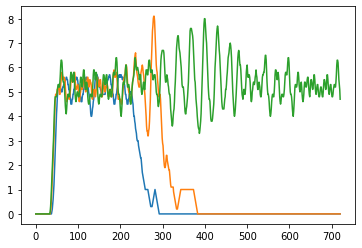

In [776]:
plt.plot(time_axis,throughput_nosignalling)
plt.plot(time_axis,throughput_equisignalling)
plt.plot(time_axis,throughput_self_regulate)

# Holland Tunnel NJ to M

In [737]:
top_G = {'A':['D'],'B':['D'],'C':['D'],'D':['F'],'E':['F'], 'F':['H'], 'G':['H'], 'H':['J'], 'I':['J'], 'J':['K']}
edges = []
for key,val in top_G.items():
    for node in val:
        edges.append(key+node)

lengths = {i:200 for i in edges}

input_edges = ['AD', 'BD', 'CD', 'EF', 'GH', 'IJ']
for edge in input_edges:
    lengths[edge] = 100

next_edge = {'AD':'DF', 'BD':'DF', 'CD':'DF', 'DF':'FH', 'EF':'FH', 'FH':'HJ', 'GH':'HJ', 'HJ':'JK', 'IJ':'JK', 'JK':None}

merges = [[['AD', 'BD', 'CD'], 'DF'],[['DF','EF'],'FH'],[['FH','GH'],'HJ'],[['HJ','IJ'],'JK']]

In [738]:
base_input_rate = {'AD':0.09, 'BD':0.09, 'CD':0.09, 'EF':0.09, 'GH':0.09, 'IJ':0.09}
burst_input_rate = {'AD':0.20, 'BD':0.25, 'CD':0.03, 'EF':0.02, 'GH':0.02, 'IJ':0.02}

In [739]:
i1, i2, i3 = 200, 200, 500

In [740]:
S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
try:
    for k in range(i1):
        S.iteration_equisignal(base_input_rate)
    for k in range(i2):
        S.iteration_equisignal(burst_input_rate)
    for k in range(i3):
        S.iteration_equisignal(base_input_rate)
except:
    pass

time_arr = np.array(S.get_throughput())
throughput_equisignalling = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
throughput_equisignalling = np.convolve(throughput_equisignalling, kernel, mode='valid')

In [741]:
S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
try:
    for k in range(i1):
        S.iteration_self_regulate(base_input_rate)
    for k in range(i2):
        S.iteration_self_regulate(burst_input_rate)
    for k in range(i3):
        S.iteration_self_regulate(base_input_rate)
except:
    pass
time_arr = np.array(S.get_throughput())
throughput_self_regulate = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
throughput_self_regulate = np.convolve(throughput_self_regulate, kernel, mode='valid')

In [742]:
S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
try:
    for k in range(i1):
        S.iteration_nosignal(base_input_rate)
    for k in range(i2):
        S.iteration_nosignal(burst_input_rate)
    for k in range(i3):
        S.iteration_nosignal(base_input_rate)
except:
    pass

time_arr = np.array(S.get_throughput())
throughput_nosignalling = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
throughput_nosignalling = np.convolve(throughput_nosignalling, kernel, mode='valid')

In [743]:
time_axis = [i for i in range(0,len(throughput_self_regulate))]

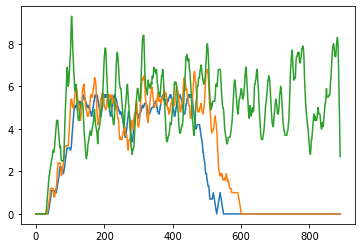

In [744]:
plt.plot(time_axis,throughput_nosignalling)
plt.plot(time_axis,throughput_equisignalling)
plt.plot(time_axis,throughput_self_regulate)